In [1]:
import pandas as pd
import numpy as np
import sys
import ast
import string
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import matplotlib.patheffects as path_effects
from forgi.graph.bulge_graph import BulgeGraph
sys.path.append(r'..\src')
from GMfold import gmfold, gm_dot_bracket
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Topic modeling  and Spectral clustring: Generate Fig. 8 of the paper.

In [2]:

def get_part_before_colon(input_string):

    if ':' in input_string:
        return input_string.split(':')[0]
    else:
        return input_string
# Function to generate BoF descriptors
def BoF_in_df(df):    
    words = []
    for i in range(len(df)):
        for j in range(len(df['faces'][i])):
            word_pair = (get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j])
            if word_pair not in words:
                words.append(word_pair)
    vecotr_list = []
    for i in range(len(df)):
        binary_array = np.zeros(len(words), dtype=int)
        for j in range(len(df['faces'][i])):
            binary_array[words.index((get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j]))] += 1
        vecotr_list.append(binary_array)
    # Apply function to each row
    df['binary_array'] = vecotr_list
    X_raw = np.zeros((len(df), len(words)), dtype=int)
    for count, desc in enumerate(df['binary_array']):
        X_raw[count, :] = desc
    
    return X_raw, words

# Generate BoF descriptors
df = pd.read_csv(r'..\data\fold_published.csv')
df['faces'] = df['faces'].apply(ast.literal_eval)
df['energy_faces'] = df['energy_faces'].apply(ast.literal_eval)
X_raw0, words0 = BoF_in_df(df)

## Topic modeling

In [3]:

# Function to run NMF
def run_nmf( X ):
    n_components = 25
    init = "nndsvda"
    nmf= NMF(
    n_components=n_components,
    random_state=42,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.99,
    ).fit(X)
    # Get the topic distribution for each point in X
    topic_distribution = nmf.transform(X)
    W = nmf.components_
    # Create a label list where each element is the topic associated with the corresponding point
    labels = [topic_probs.argmax() for topic_probs in topic_distribution]
    #plot_top_words(nmf, np.asarray(words)[mask], n_top_words, "Topics in LDA model")
    return labels, topic_distribution,  W,  n_components 

#Run NMF
labels , topic,  W ,  n_components = run_nmf(X_raw0)
# Run TSNE algorithm for dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=50).fit_transform(topic)


## Spectral clustering

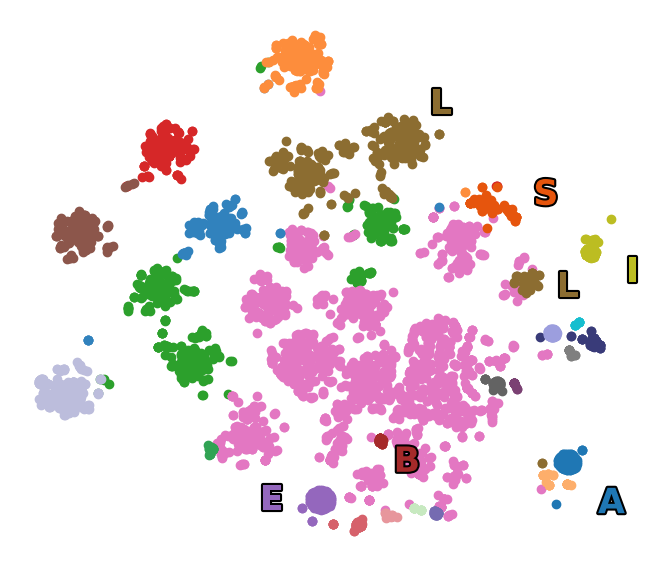

In [4]:
# Scatter plot in Fig. 8 of the paper
n_clusters = 25  # Define the number of clusters
# Run spectral clustering algorithm
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

# Fit the model and predict cluster labels
cluster_labels = spectral_clustering.fit_predict(topic)

# Define the letters and color or general use
#letters = list(string.ascii_uppercase[:n_clusters])   
#colors = [
#   '#1f77b4', 'brown', '#2ca02c', '#d62728', '#9467bd',
#  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
#  '#393b79', '#8c6d31', '#d6616b', '#7b4173', '#3182bd',
#    '#9c9ede', '#756bb1', '#636363', '#e6550d', '#fd8d3c',
#   '#31a354', '#c7e9c0', '#fdae6b', '#e7969c', '#bcbddc']
 
# Define the letters and color to replicate resutls ( Spectral clustering may swap labels for cluster which would lead to different plots)
letters ={97: 'A',27: 'B',471: 'C',169: 'D',111: 'E',157: 'F',1921: 'G',14: 'H',69: 'I',11: 'J',58: 'K',
               442: 'L',44: 'M',16: 'N',153: 'O',51: 'P',29: 'Q',49: 'R',89: 'S',191: 'T',18: 'U',19: 'V',31: 'W',22: 'X'} #To reproduce results


colors ={97: '#1f77b4', 27: 'brown', 471: '#2ca02c', 169: '#d62728', 111: '#9467bd', 157: '#8c564b', 1921: '#e377c2', 14: '#7f7f7f',
         69: '#bcbd22', 11: '#17becf', 58: '#393b79', 442: '#8c6d31', 44: '#d6616b', 16: '#7b4173', 153: '#3182bd', 51: '#9c9ede', 
         29: '#756bb1', 49: '#636363', 89: '#e6550d', 191: '#bcbddc', 18: '#31a354', 19: '#c7e9c0', 31: '#fdae6b', 22: '#e7969c'}

# Indices of clusters to highlight with letters. The clusters highlighted are those containing at least an high count sequence. 
# Where a sequence is defined to be high count if its count is larger than 1000
highlight_indices = set(cluster_labels[df['Count'] >=1000])

# Invert the x and y coordinates to rotate by 180° 
X_embedded_rotated = -X_embedded

# Plot each cluster
plt.figure(figsize=(7, 6))
for cluster_idx in range(n_clusters):
    if np.count_nonzero(cluster_labels ==cluster_idx) == 191:
        if 54 in np.where(cluster_labels ==cluster_idx)[0]:
            colors[191]= '#fd8d3c'
            letters[191]='T'
        else:
            colors[191]= '#bcbddc'
            letters[191]= 'Y'
            
    cluster_points = X_embedded_rotated[cluster_labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)], label=f'Cluster {cluster_idx+1}')
    
    # Add a letter near clusters with specified indices
    if cluster_idx in highlight_indices:
        # Calculate the position to place the letter on the right of the cluster
        max_x = np.max(cluster_points[:, 0])
        mean_y = np.mean(cluster_points[:, 1])
        if np.count_nonzero(cluster_labels ==cluster_idx) == 69:
            plt.text(max_x +3, mean_y - 4.7, letters[69], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif np.count_nonzero(cluster_labels ==cluster_idx) == 97:
            plt.text(max_x +3.2, mean_y-9 , letters[97], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif np.count_nonzero(cluster_labels ==cluster_idx) == 442:
            plt.text(max_x/2-2 , mean_y +15 , letters[442], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                    fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
            plt.text(max_x +3, mean_y -25, letters[442], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif np.count_nonzero(cluster_labels ==cluster_idx) == 89:
            plt.text(max_x +3.5 , mean_y +2.5, letters[89], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif np.count_nonzero(cluster_labels ==cluster_idx) == 111:
            plt.text(max_x -14 , mean_y , letters[111], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        else:
            plt.text(max_x + 2.2, mean_y - 4.7, letters[27], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])

cluster_idx = 1
cluster_points = X_embedded_rotated[cluster_labels == cluster_idx]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[np.count_nonzero(cluster_labels ==cluster_idx)], label=f'Cluster {cluster_idx+1}')
plt.tight_layout()
plt.axis('off')
plt.show()


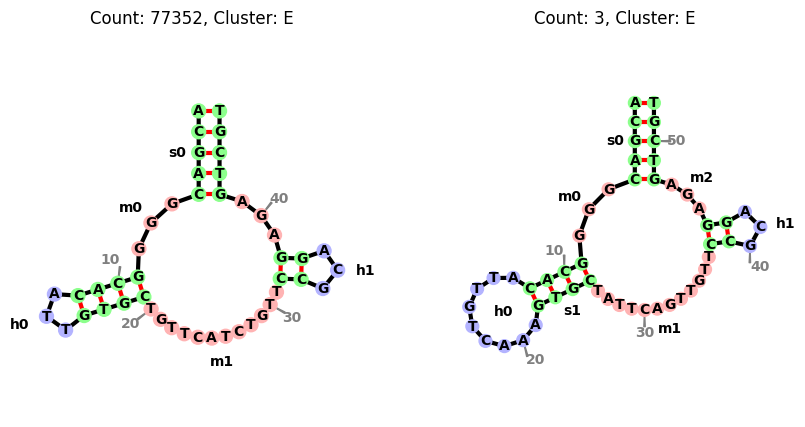

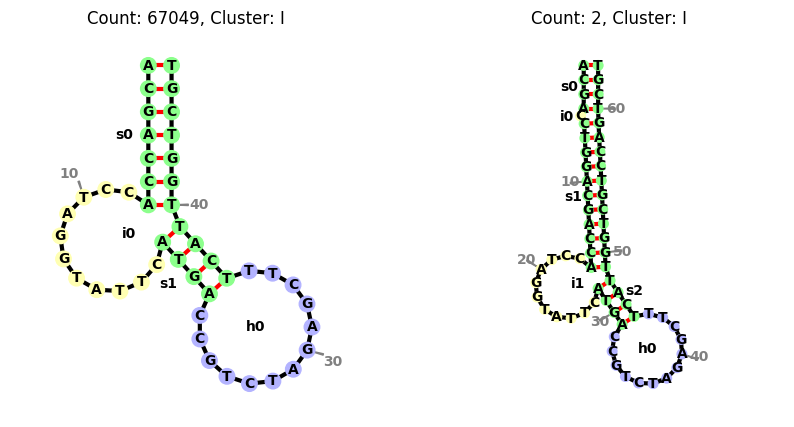

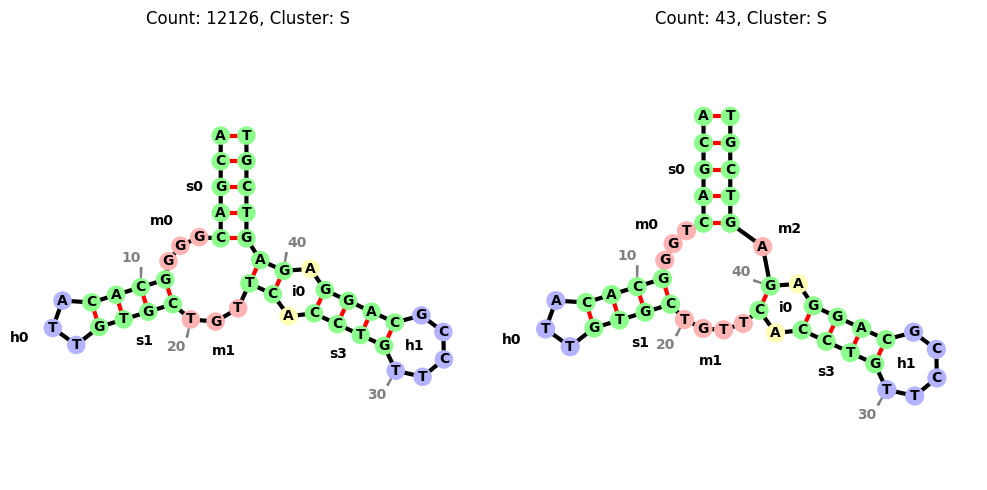

In [5]:
# DNA sequences represented in Fig. 8 and highest count sequence in relative cluster
index_x1 =[0,3298]
index_x2=[1, 3397 ]
index_x3 =[2, 48]
for lista in [index_x1, index_x2, index_x3]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        seq = df['Sequence'][lista[0]]
        structs = gmfold(seq, l_fix = 4)
        d_b = gm_dot_bracket( seq, structs)
        bg = BulgeGraph.from_dotbracket( d_b  ,  seq)
        fvm.plot_rna(bg,ax = ax1, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
        ax1.set_title(f'Count: {df['Count'][lista[0]]}, Cluster: {letters[np.count_nonzero(cluster_labels ==cluster_labels[lista[0]])]}')
        seq = df['Sequence'][lista[1]]
        structs = gmfold(seq, l_fix = 4)
        d_b = gm_dot_bracket( seq, structs)
        bg = BulgeGraph.from_dotbracket( d_b  ,  seq)
        fvm.plot_rna(bg,ax = ax2, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
        ax2.set_title(f'Count: {df['Count'][lista[1]]}, Cluster: {letters[np.count_nonzero(cluster_labels ==cluster_labels[lista[0]])]}')
        
plt.tight_layout()
plt.axis('off')
plt.show()

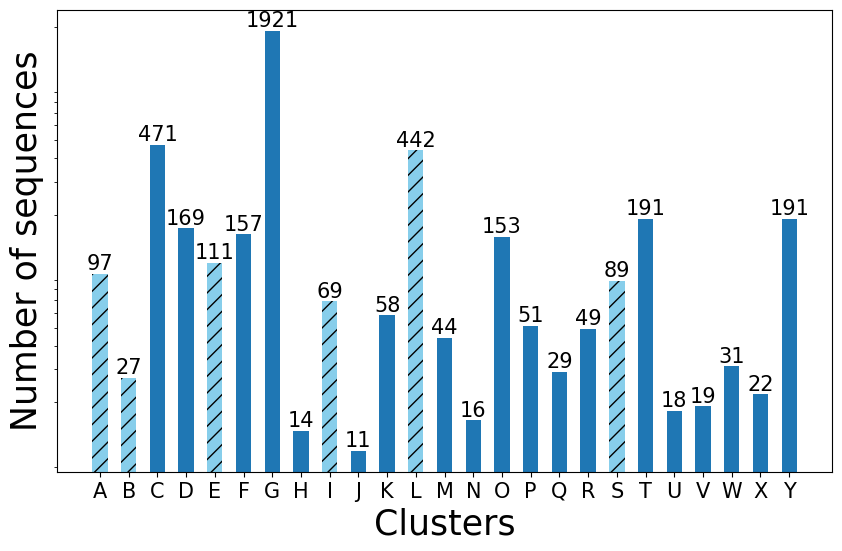

In [6]:
# Bar plot in Fig. 8 of the paper
plt.figure(figsize=(10, 6))
arr_lab = np.asarray(cluster_labels)
arr_lab_hc = np.asarray(cluster_labels)[df['Count'] >= 1000]

d = n_components  # Number of unique labels

# Count occurrences of each label
counts = np.bincount(arr_lab, minlength=d)
counts_hc = np.bincount(arr_lab_hc, minlength=d)

# Increase spacing between bars by modifying x positions
spacing_multiplier = 1.5  # Adjust this value to control the space between bars
x_positions = np.arange(d) * spacing_multiplier  # Increasing spacing between bars

# Create the bar plot with increased spacing
bars = plt.bar(x_positions, counts)

# Highlight the bar at the given index with stripes and add counts on top
for i, bar in enumerate(bars):
    height = bar.get_height()
    if counts_hc[i] > 0:
        # Apply hatching (stripes) to the specific bar
        bar.set_hatch('//')
        bar.set_facecolor('skyblue')
    
    # Add the count on top of each bar
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=15)

# Generate letters for x-ticks
x_letters = []
flag = 0
for c in counts:
    if c == 191:
        if flag == 0:
            flag =1
            x_letters.append('T')
        else:
            x_letters.append('Y')
    else:
        x_letters.append(letters[c])
plt.yscale('log')# Set y-axis to log scale
plt.yticks([])
plt.xticks(x_positions, x_letters, fontsize=15)
plt.xlabel('Clusters', fontsize=25)
plt.ylabel('Number of sequences', fontsize=25)
plt.show()



In [7]:
s = set(cluster_labels[df['Count'] >=1000])
sum_elem = 0
for  c in s:
    sum_elem += np.count_nonzero(cluster_labels ==c)

   
print('Amount of elements in clusters containing at least on high_count sequence:', sum_elem)

Amount of elements in clusters containing at least on high_count sequence: 835
